In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import statsmodels.api as sm
from scipy import stats


sys.path.append("../EDA")
import movie_data_formatter as mdf
import movie_rating_popularity_year as mrpy
import general_functions as gf

sns.set_theme(style="whitegrid", font_scale=1.1)

DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005


In [3]:

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_movie_reviews_table(df)
movie_popular_data = mrpy.get_movie_aggregation(processed_data)


# Question 1: 

Are movies that are more popular (operationalized as having more ratings) rated higher than movies that 
are less popular? [Hint: You can do a median-split of popularity to determine high vs. low popularity movies]  

# Visualizations


From the visualization, we can notice that when the popularity level is low, the average rating tends to between 2.0 to 2.2 whereas when popularity level is high
the the range tends to be between 2.7 and 3.1.

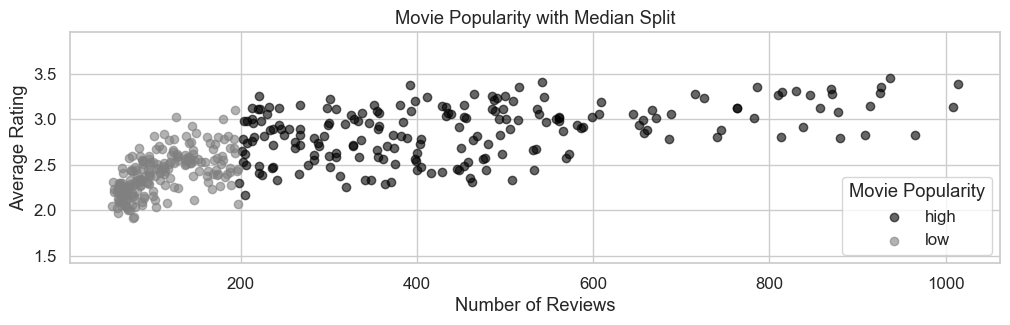

In [4]:
plt = mrpy.plot_popular_median_split(movie_popular_data, show=False)

# place legend on the right bottom of the plot
plt.legend(loc='lower right', title='Movie Popularity')

# save as pdf
plt.savefig('../figures/avg_rating_popularity.pdf', bbox_inches='tight')

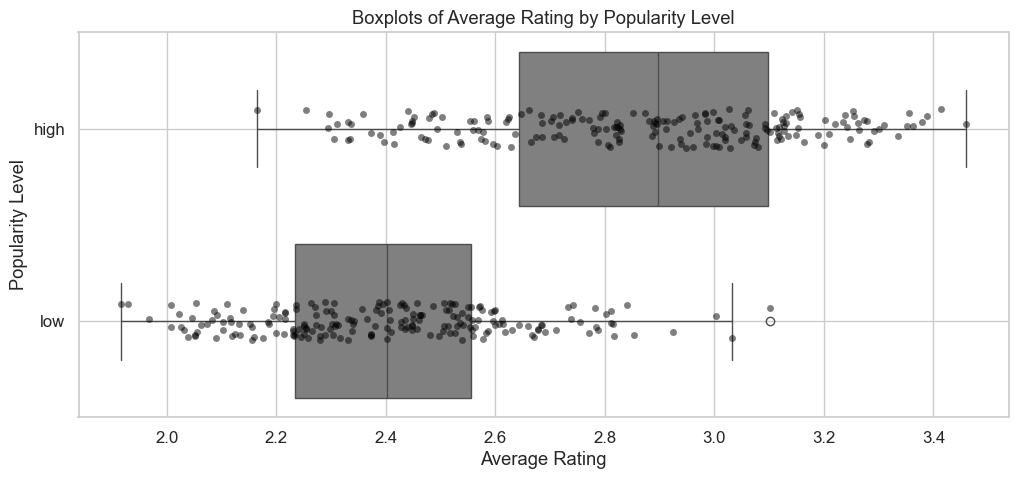

In [5]:
box_plot_variance = mrpy.boxplot_popularity_median_split(movie_popular_data, show=False)

# save as pdf
box_plot_variance.savefig('../figures/box_plot_popularity_level.pdf', bbox_inches='tight')

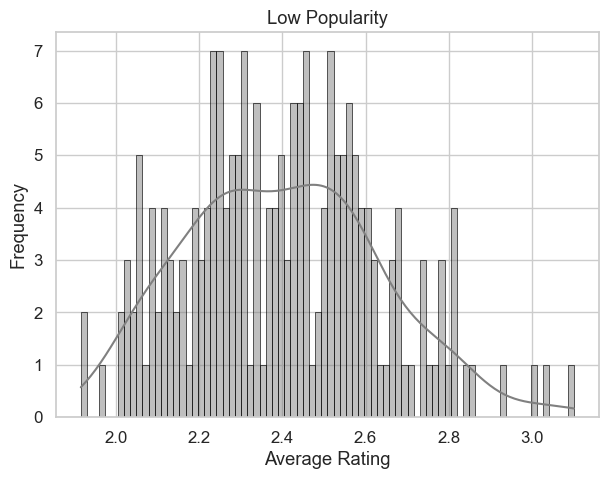

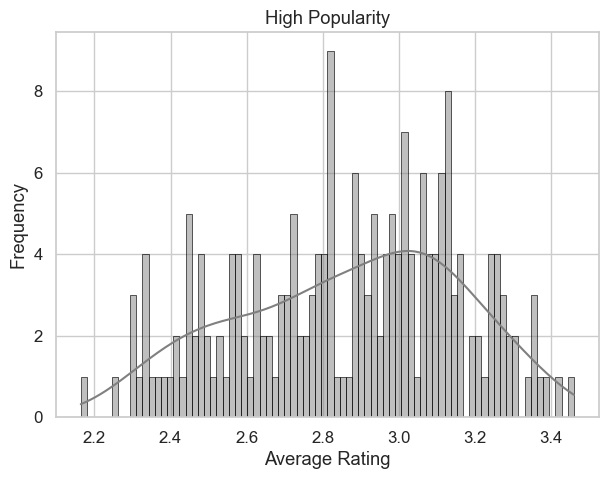

<module 'matplotlib.pyplot' from '/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [6]:
lowest_popular = movie_popular_data[movie_popular_data['popularity_level'] == 'low']
highest_popular = movie_popular_data[movie_popular_data['popularity_level'] == 'high']
gf.plot_distrubtion(lowest_popular, "Low Popularity", y='average_rating', show=True, bins = 80)
gf.plot_distrubtion(highest_popular, "High Popularity", y='average_rating', show=True, bins = 80)


/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


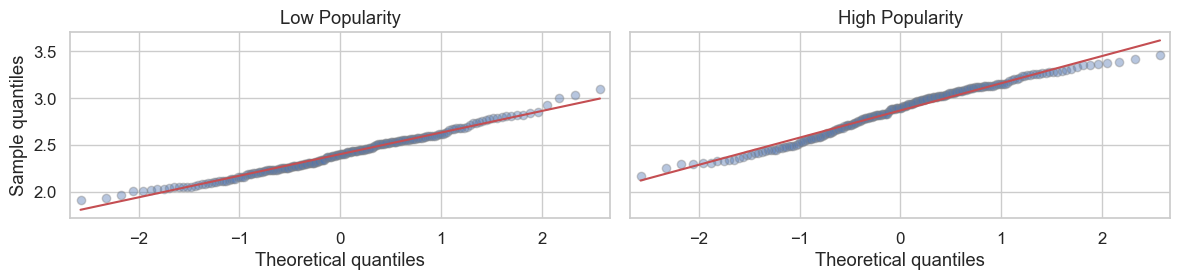

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)

x_low  = lowest_popular["average_rating"].astype(float).to_numpy()
x_high = highest_popular["average_rating"].astype(float).to_numpy()
x_low  = x_low[np.isfinite(x_low)]
x_high = x_high[np.isfinite(x_high)]

# Use a scipy.stats distribution object
sm.ProbPlot(x_low,  dist=stats.norm).qqplot(ax=ax1, line="s", marker="o", markersize=6, alpha=0.4, color='black')
sm.ProbPlot(x_high, dist=stats.norm).qqplot(ax=ax2, line="s", marker="o", markersize=6, alpha=0.4, color='black')


# set the colors of the circles to grey with edgecolor black
ax1.get_lines()[0].set_color('lightgrey'); ax1.get_lines()[0].set_markeredgecolor('grey')
ax2.get_lines()[0].set_color('lightgrey'); ax2.get_lines()[0].set_markeredgecolor('grey')


ax1.set_title("Low Popularity");  ax2.set_title("High Popularity")
ax1.set_xlabel("Theoretical quantiles"); ax1.set_ylabel("Sample quantiles")
ax2.set_xlabel("Theoretical quantiles"); ax2.set_ylabel("")

fig.tight_layout()


# save as pdf -- no color
fig.savefig('../figures/qq_plot_popularity.pdf')


In [15]:
# table of variance and mean for each popularity level
variance_table = movie_popular_data.groupby('popularity_level')['average_rating'].agg(['count', 'mean', 'median', 'var', 'std']).reset_index()

s1, s2 = np.var(lowest_popular['average_rating']), np.var(highest_popular['average_rating'])
n1, n2 = len(lowest_popular['average_rating']), len(highest_popular['average_rating'])

gf.welch_df(s1, s2, n1, n2).round(4)

np.float64(378.5357)

# Hypothesis Testing



## Mann–Whitney U test
We will use a Mann–Whitney U test because:
- The two groups (low-popularity and high-popularity movies) are independent.
- The rating distributions are non-normal and not perfectly similar in shape, violating the assumptions of parametric tests like the t-test.
- The Mann–Whitney U test does not assume normality and is robust to unequal variances and outliers.
- It allows for a one-sided hypothesis, aligning with our research question about whether high-popularity movies tend to receive higher ratings.

### Setup 
Let:
- X1 = Ratings of low-popularity movies
- X2 = Ratings of high-popularity movies

H0 : The distributions of X1 and X2 are identical.

H1 : X2 tends to yield larger values than X1.

This is a right-tailed (one-sided) Mann–Whitney U test, testing whether high-popularity movies have higher median ratings.

In [9]:
stat, p = stats.mannwhitneyu(lowest_popular['average_rating'], highest_popular['average_rating'], alternative='less')


# calculate the df

gf.is_p_drop("Mann-Whitney U Test", stat, p, "median", ALPHA)

Mann-Whitney U Test: 4596.000, p-value: 0.0000
Drop H0 --> accept H1


The Kruskal–Wallis H test revealed a significant difference among groups.  

## Welch’s t-test
Since the low-popularity and high-popularity movie groups are not extremely skewed and each contains at least 30 observations, 
the Central Limit Theorem allows us to assume approximate normality of the sampling distribution of the mean.

Therefore, a Welch’s t-test (which does not assume equal variances) is appropriate for comparing the average ratings 
between the two groups.

### Setup

Let:
- u1 = mean rating for low-popularity movies
- u2 = mean rating for high-popularity movies

We want to test whether high popularity leads to higher observed ratings.

H0: u1 = u2
H1: u2 > u1


In [10]:
stat, p = stats.ttest_ind(lowest_popular['average_rating'], 
                          highest_popular['average_rating'], 
                          equal_var=False, alternative='less')

gf.is_p_drop("T-test", stat, p, ALPHA)
p

T-test: -17.756, p-value: 0.0000
Drop H0 --> accept H1


np.float64(4.768468295426455e-52)

Since the p-value is effectively 0.0000 (< 0.05), we drop the null hypothesis.
There is strong statistical evidence that high-popularity movies have significantly higher average ratings compared to low-popularity movies. 

In other words, popularity level is positively associated with average rating -- more popular movies tend to receive better audience evaluations.

# Conclusion 

We performed both a Welch’s t-test and a Mann–Whitney U test to assess whether 
high-popularity movies have higher ratings than low-popularity movies.

Both tests produced p-values < 0.001, leading us to reject the null hypothesis 
and conclude that high-popularity movies tend to have significantly higher 
ratings. The agreement between parametric (mean-based) and non-parametric 
(rank-based) results increases confidence in this finding.
